# variational Latent Gaussian Process

This tutorial shows how to use the code to reproduce part of the result in the paper.

Import modules.

In [1]:
import os
from os import path as op

import numpy as np
from scipy import stats
from scipy import linalg

import vlgp
from vlgp import util, simulation

Then import and set up graphics. Borrow the palette from seaborn. 

In [2]:
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Create the paths to the data and ouput directories. These two subdirectories are expected to exist in current directory.

In [3]:
datapath = op.abspath('../data')
outputpath = op.abspath('../output')

## Lorenz Dynamics

We simulate a dataset driven by 3-dimensional Lorenz dynamics defined by the following differential equations,
\begin{align} 
    x_1' &= \sigma(x_2 - x_1)     \\
    x_2' &= x_1(\rho - x_3) - x_2 \\
    x_3' &= x_1 x_2 - \beta x_3.
\end{align}

Each sample consists of 10 trials of 50 spike trains. Each trial contains 1000 time bins. The discrete latent dynamics are sampled with the time step of 0.0015. The parameters are set to $\sigma=10$, $\rho=28$ and $\beta=2.667$. We normalize the dynamics and discard the first 2000 points to get stable result.

In [4]:
ntrial = 10  # number of trials
nbin = 500  # number of time bins of each trial
nneuron = 50 # number of neurons (spike trains)
dim = 3 # latent dimension

To reproduce the same results as that in the paper, set the random seed and simulate 5 samples.

In [5]:
np.random.seed(0)
skip = 500
lorenz = simulation.lorenz(skip +  ntrial * nbin, dt=5e-3, s=10, r=28, b=2.667, x0=np.random.random(dim))
lorenz = stats.zscore(lorenz[skip:, :]) 
x = lorenz.reshape((ntrial, nbin, dim))  # latent dynamics in proper shape

Plot the first trial.

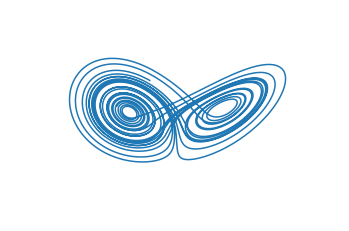

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*lorenz.T)
plt.axis("off")
plt.show()
plt.close()

Then simulate spike trains with 10-step history filter given the simulated latent dynamics. The elements of loading matrix is randomly generated from $(1, 2)$ with random signs. The base firing rate is 15Hz. 

The simulation function `simulation.spike` gives spike trains, design matrix of regression part and the true firing rates. We sort the loading matrix by row.

In [7]:
np.random.seed(0)
bias = np.log(15 / nbin)  # log base firing rate
a = (np.random.rand(dim, nneuron) + 1) * np.sign(np.random.randn(dim, nneuron)) # loading matrix
b = np.vstack((bias * np.ones(nneuron), -10 * np.ones(nneuron), -10 * np.ones(nneuron), -3 * np.ones(nneuron), 
                  -3 * np.ones(nneuron), -3 * np.ones(nneuron), -3 * np.ones(nneuron), -2 * np.ones(nneuron),
                  -2 * np.ones(nneuron), -1 * np.ones(nneuron), -1 * np.ones(nneuron)))  # regression weights

y, _, rate = simulation.spike(x, a, b)
sample = dict(y=y, rate=rate, x=x, alpha=a, beta=b)

Load the first sample and plot the spike trains.

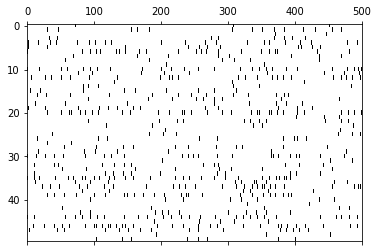

In [8]:
# Raster plot
plt.figure()
plt.spy(sample['y'][0, ...].T, aspect='auto')
plt.show()
plt.close()

### Model Fitting

Now let us do inference on the first sample. Firstly we need to set the random seed in order to get reproducible result because the algorithm does subsampling in the hyperparameters optimization steps. 

The `fit` function requires the observations, as a list of `dict` that represents a trial each. Each trial at least contains a identifier `ID` and the observation array `y` in the shape of `(bin, channel)`. 

In [9]:
np.random.seed(0)

trials = [{'ID': i, 'y': y} for i, y in enumerate(sample['y'])]  # make trials

fit = vlgp.fit(
    trials,  
    n_factors=3,  # dimensionality of latent process
    max_iter=20,  # maximum number of iterations
    min_iter=10  # minimum number of iterations
)

Initializing
Initialized
Fitting
Iteration    1, E-step 4.93s, M-step 1.11s
Iteration    2, E-step 4.92s, M-step 1.07s
Iteration    3, E-step 4.89s, M-step 1.04s
Iteration    4, E-step 6.09s, M-step 1.03s
Iteration    5, E-step 6.24s, M-step 1.13s
Iteration    6, E-step 4.76s, M-step 1.06s
Iteration    7, E-step 4.74s, M-step 1.00s
Iteration    8, E-step 4.95s, M-step 1.00s
Iteration    9, E-step 4.86s, M-step 1.01s
Iteration   10, E-step 4.82s, M-step 1.00s
Iteration   11, E-step 4.74s, M-step 1.09s
Iteration   12, E-step 6.62s, M-step 1.12s
Iteration   13, E-step 6.49s, M-step 1.12s
Iteration   14, E-step 6.45s, M-step 1.07s
Iteration   15, E-step 5.97s, M-step 1.13s
Iteration   16, E-step 6.42s, M-step 1.08s
Iteration   17, E-step 6.09s, M-step 1.17s
Iteration   18, E-step 6.55s, M-step 1.19s
Iteration   19, E-step 6.45s, M-step 1.14s
Iteration   20, E-step 6.43s, M-step 1.13s
Done


The `fit` function returns a `dict` as the result containing `trials` which is a list of trials with the original observation and inferred latent states. The resulting `dict` also contains `parameter` where the parameters, such as the loading matrix and bias, are stored.

In [10]:
trials = fit['trials']  # extract trials
mu = trials[0]['mu']  # extract posterior latent
W = np.linalg.lstsq(mu, x[0, ...], rcond=None)[0]
mu = mu @ W

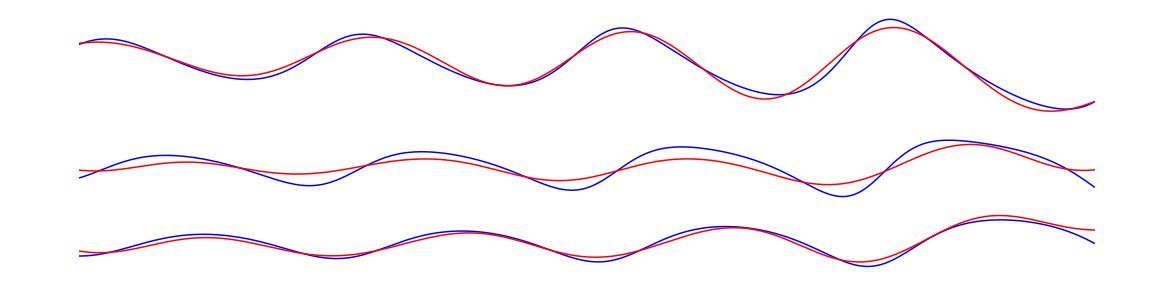

In [11]:
# Plot posterior latent
plt.figure(figsize=(20, 5))
plt.plot(x[0, ...] + 2 * np.arange(3), color="b")
plt.plot(mu + 2 * np.arange(3), color="r")
plt.axis("off")
plt.show()
plt.close()

## posterior covariance

In [61]:
kTrial = 0;
trial = fit['trials'][kTrial]

In [62]:
samples = vlgp.sample_posterior(trial, fit['params'], 10, reg=1e-6)

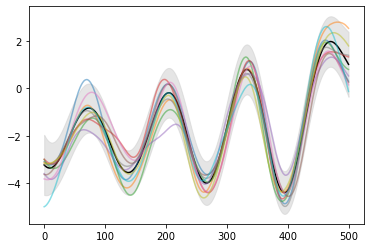

In [67]:
plt.figure()
mu = trial['mu']
v = trial['v'] # marginal variance
s = np.sqrt(v)
kFactor = 0
plt.fill_between(np.arange(mu.shape[0]), mu[:,kFactor]-2*s[:,kFactor], mu[:,kFactor]+2*s[:,kFactor], color=[.8,.8,.8], alpha=0.5)
plt.plot(mu[:,kFactor], 'k')
plt.plot(samples[:,:,kFactor].T, alpha=0.5);